Epoch 1/15
79/79 - 17s - loss: 1.1026 - accuracy: 0.3623 - val_loss: 1.0691 - val_accuracy: 0.4382 - 17s/epoch - 212ms/step
Epoch 2/15
79/79 - 6s - loss: 0.9632 - accuracy: 0.5468 - val_loss: 0.9001 - val_accuracy: 0.6156 - 6s/epoch - 77ms/step
Epoch 3/15
79/79 - 6s - loss: 0.8117 - accuracy: 0.6627 - val_loss: 0.7722 - val_accuracy: 0.6586 - 6s/epoch - 79ms/step
Epoch 4/15
79/79 - 6s - loss: 0.7279 - accuracy: 0.6893 - val_loss: 0.7448 - val_accuracy: 0.6183 - 6s/epoch - 82ms/step
Epoch 5/15
79/79 - 6s - loss: 0.6934 - accuracy: 0.6877 - val_loss: 0.6954 - val_accuracy: 0.6747 - 6s/epoch - 79ms/step
Epoch 6/15
79/79 - 7s - loss: 0.6662 - accuracy: 0.6929 - val_loss: 0.6682 - val_accuracy: 0.7151 - 7s/epoch - 83ms/step
Epoch 7/15
79/79 - 7s - loss: 0.6447 - accuracy: 0.6810 - val_loss: 0.6567 - val_accuracy: 0.6747 - 7s/epoch - 85ms/step
Epoch 8/15
79/79 - 6s - loss: 0.6166 - accuracy: 0.6849 - val_loss: 0.6710 - val_accuracy: 0.5995 - 6s/epoch - 77ms/step
Epoch 9/15
79/79 - 6s - loss:

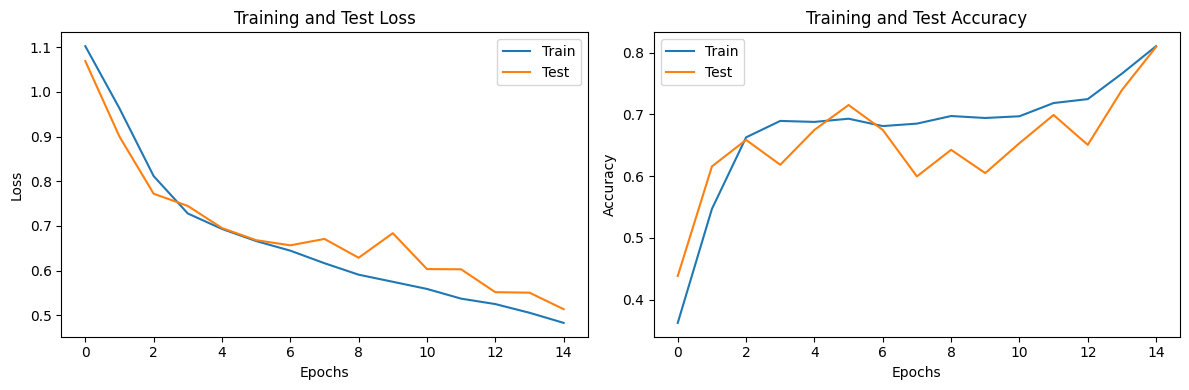

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

dataset_name = "rock_paper_scissors"
ds_info = tfds.builder(dataset_name).info
num_classes = ds_info.features["label"].num_classes


base_model = MobileNetV2(input_shape=(192, 192, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = Sequential()

model.add(base_model)

model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.7))

model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(Dropout(0.7))

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_dataset = tfds.load(dataset_name, split='train', as_supervised=True)
test_dataset = tfds.load(dataset_name, split='test', as_supervised=True)

def preprocess(image, label):
    image = tf.image.resize(image, (192, 192))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

train_dataset = train_dataset.map(preprocess)
train_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.batch(32).shuffle(buffer_size=1000)
test_dataset = test_dataset.map(preprocess)
test_dataset = test_dataset.batch(32)

epochs = 15
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=len(train_dataset),
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    verbose=2
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
model.save("/content/my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 70.0 MB/s eta 0:00:00


In [15]:
!tensorflowjs_converter \
    --input_format=keras \
    my_model.h5 \
    my_tfjs_model

2024-03-06 12:33:10.557068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 12:33:10.557126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 12:33:10.558303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 12:33:11.623604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from google.colab import files
files.download("/content/my_tfjs_model")